## **EXERCÍCIO 06 - Custom Dataset**

## **CESAR SCHOOL**
* Pós-graduação em Engenharia e Análise de Dados - 2023.2
* **Disciplina: Tópicos Complementares**
* Professor: **Silvan Ferreira**
* Aluno: **Allan Bispo** - apsb@cesar.school

## Exercício
Um dataset sintético contendo alguns exemplos de diferentes formas básicas é criado. Em seguida, crie um dataset e um modelo convolucional que classifique o formato na imagem.

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Parâmetros
image_size = 64
num_examples = 2000
num_classes = 5
output_file = "/content/data/synthetic.csv"

In [ ]:
# Função para gerar uma imagem de uma determinada classe
def generate_image(label):
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    if label == 0:
        # Classe 0: Círculos
        center = (np.random.randint(10, image_size-10), np.random.randint(10, image_size-10))
        radius = np.random.randint(5, 10)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.circle(image, center, radius, color, -1)
    elif label == 1:
        # Classe 1: Triângulos equiláteros
        side_length = np.random.randint(10, 20)
        height = int(np.sqrt(3)/2 * side_length)
        center = (np.random.randint(side_length//2, image_size-side_length//2),
                  np.random.randint(height//2, image_size-height//2))
        pts = np.array([[center[0], center[1] - 2*height//3],
                        [center[0] - side_length//2, center[1] + height//3],
                        [center[0] + side_length//2, center[1] + height//3]], np.int32)
        pts = pts.reshape((-1, 1, 2))
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.fillPoly(image, [pts], color)
    elif label == 2:
        # Classe 2: Linhas Horizontais
        y = np.random.randint(5, image_size-5)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        thickness = np.random.randint(1, 3)
        cv2.line(image, (0, y), (image_size, y), color, thickness)
    elif label == 3:
        # Classe 3: Quadrados
        top_left = (np.random.randint(10, image_size-10), np.random.randint(10, image_size-10))
        size = np.random.randint(5, 10)
        bottom_right = (top_left[0] + size, top_left[1] + size)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.rectangle(image, top_left, bottom_right, color, -1)
    elif label == 4:
        # Classe 4: Linhas Verticais
        x = np.random.randint(5, image_size-5)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        thickness = np.random.randint(1, 3)
        cv2.line(image, (x, 0), (x, image_size), color, thickness)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def show_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

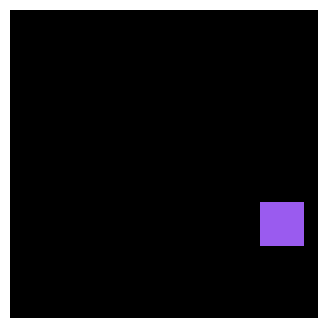

In [ ]:
show_image(generate_image(3))

In [ ]:
data = []
labels = []
for _ in tqdm(range(num_examples)):
    label = np.random.randint(0, num_classes)
    image = generate_image(label).flatten()
    data.append(np.concatenate(([label], image)))
    labels.append(label)

data = np.array(data)

# Salvando em CSV
df = pd.DataFrame(data)
df.to_csv(output_file, index=False, header=False)

print(f"Dataset salvo em {output_file}")

100%|██████████| 2000/2000 [00:00<00:00, 13287.62it/s]


Dataset salvo em /content/data/synthetic.csv


## Agora é com você!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Definição da classe SyntheticCSVLoader para carregar o dataset a partir de um arquivo CSV.
#     Baseie-se no MNISTDataset do notebook "04 - Basic CNNs.ipynb"

class SyntheticCSVLoader(Dataset):
    def __init__(self, csv_file, image_size=64, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem (64x64x3)
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(64, 64, 3)

        # Converte a imagem para tensor e ajusta os eixos para o formato (C, H, W)
        image = torch.tensor(image).permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
synthetic_dataset = SyntheticCSVLoader(
    csv_file="data/synthetic.csv",
    transform=transform
)

In [ ]:
# Dividindo o dataset em conjuntos de treino e teste

# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(synthetic_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(synthetic_dataset, train_indices)
valset = Subset(synthetic_dataset, val_indices)
testset = Subset(synthetic_dataset, test_indices)

In [ ]:
# Criando DataLoaders para os subsets

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)  # Adjusted the input channels to 3 for RGB images and increased the number of filters
        self.conv2 = nn.Conv2d(16, 32, 5)  # Increased the number of filters
        self.fc1 = nn.Linear(32 * 13 * 13, 128)  # Adjusted the input features to match the flattened size after convolutions
        self.fc2 = nn.Linear(128, 64)  # Adjusted the size of this layer
        self.fc3 = nn.Linear(64, 10)  # Added an additional fully connected layer for more complexity
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 32 * 13 * 13)  # Adjusted to match the output of conv2 layer
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))  # Additional fully connected layer with dropout
        x = self.fc3(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
model = CNN(initialize_weights=True, dropout=0.2)

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Epoch 1, Train Loss: 0.514, Train Accuracy: 77.70%
Epoch 1, Val Loss: 0.665, Val Accuracy: 73.00%


100%|██████████| 16/16 [00:03<00:00,  4.64it/s]


Epoch 2, Train Loss: 0.413, Train Accuracy: 83.80%
Epoch 2, Val Loss: 0.603, Val Accuracy: 77.60%


100%|██████████| 16/16 [00:03<00:00,  4.38it/s]


Epoch 3, Train Loss: 0.333, Train Accuracy: 86.80%
Epoch 3, Val Loss: 0.629, Val Accuracy: 75.20%


100%|██████████| 16/16 [00:03<00:00,  4.04it/s]


Epoch 4, Train Loss: 0.302, Train Accuracy: 88.60%
Epoch 4, Val Loss: 0.611, Val Accuracy: 79.00%


100%|██████████| 16/16 [00:03<00:00,  4.79it/s]


Epoch 5, Train Loss: 0.238, Train Accuracy: 90.90%
Epoch 5, Val Loss: 0.554, Val Accuracy: 79.20%
Treinamento concluído


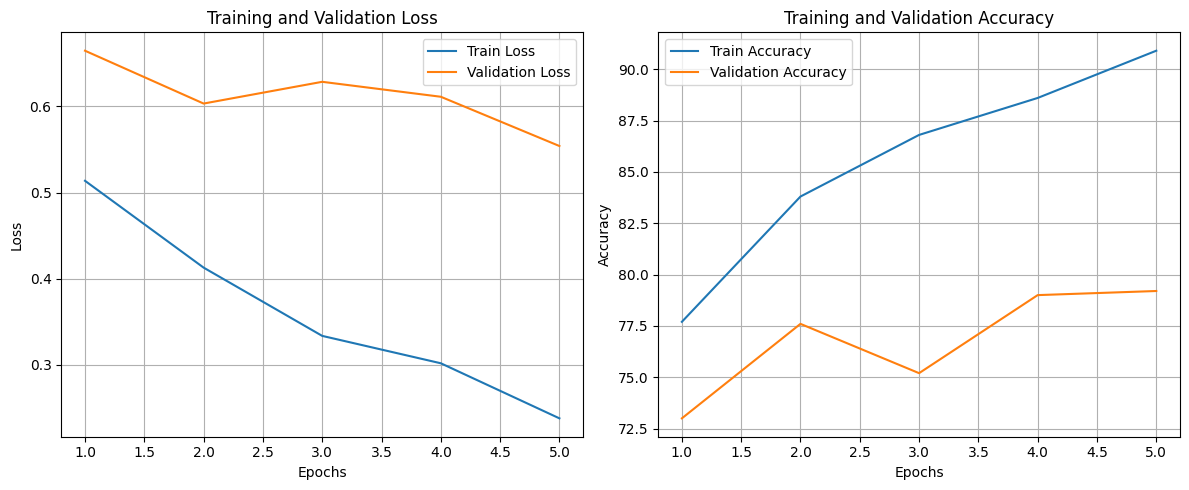

In [ ]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Teste
test_model(model, testloader)

Acurácia da rede na base de teste: 82.80%
